### BBMASTER using TOAST filtering

The toast filtering is equivalent to running all the previous notebooks, for a **5hr observation**
schedule (~half of the full South patch). I'm using the input maps created in Sec. 2 as my validation sims.

The filters include all the TOAST and sotodlib filters presented in the previous notebooks, and including the beam.

In [2]:
import bbmaster 
from bbmaster.utils import PipelineManager
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import sacc

   0.000: Log timestamps are relative to 2023-11-22 05:59:55,451 (INFO)


In [3]:
env_python_path = '/pscratch/sd/s/susannaz/conda_envs/master_env/bin/python3'

In [4]:
typesim = 'TOAST'
config = f'data/globals_{typesim}.yml' 
outdir = f'bbmaster/outputs_5hrs/'

### Generate power-law sims

In [4]:
#! {env_python_path} data/gen_PL_sims.py

### Compute MCM

In [5]:
! {env_python_path} -m bbmaster.mcmer --globals={config} --output-dir={outdir} --plot

   0.000: Log timestamps are relative to 2023-11-22 06:00:14,365 (INFO)
/pscratch/sd/s/susannaz/BBFLP/outputs_5hrs/output_maps_res0.00035rad/mask_apo15.0.fits
Reading mask
Computing MCM
bbmaster/outputs_5hrs/
Saving to bbmaster/outputs_5hrs/mcm/mcm.npz
Plotting
bbmaster/outputs_5hrs/mcm/mcm.png


![title](bbmaster/outputs_5hrs/mcm/mcm.png)

### Filter 2 PL simulation

In [23]:
#! {env_python_path} -m bbmaster.filterer_toast --globals={config} --first-sim=0 --num-sims=2 --sim-sorter=pl_sim_names --output-dir={outdir}   
#! {env_python_path} -m bbmaster.filterer_mcut --globals={config} --first-sim=0 --num-sims=10 --sim-sorter=pl_sim_names --output-dir={outdir}  --m-cut 30 #--plot

   0.000: Log timestamps are relative to 2023-11-22 07:05:48,048 (INFO)
data/PL/plsim_1000_E.fits
bbmaster/outputs_5hrs/filter_PL/plsim_1000_E.fits
bbmaster/outputs_5hrs/filter_PL/plsim_1000_E/
Read schedule
TOAST INFO: Loading schedule from data/schedules/schedule_sat_5hr.txt
TOAST INFO: Loaded 16 scans from data/schedules/schedule_sat_5hr.txt totaling 5.32 hours.
Initialize focal plane and telescope
Apply filters
TOAST INFO: Pixel data in data/PL/plsim_1000_E.fits does not have TUNIT1 key.  Assuming 'K'.
Save hdf5 and context files
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_PL/plsim_1000_E/obs_south-0-0_959754943.h5
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_PL/plsim_1000_E/obs_south-0-1_1992400164.h5
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_PL/plsim_1000_E/obs_south-0-2_2319226194.h5
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_PL/plsim_1000_E/obs_south-0-3_3673067510.h5
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_PL/plsim_1000_E/obs_south-0-4_2220424676.h5
TOAST 

Manually plot for 1 sim

<Figure size 640x480 with 0 Axes>

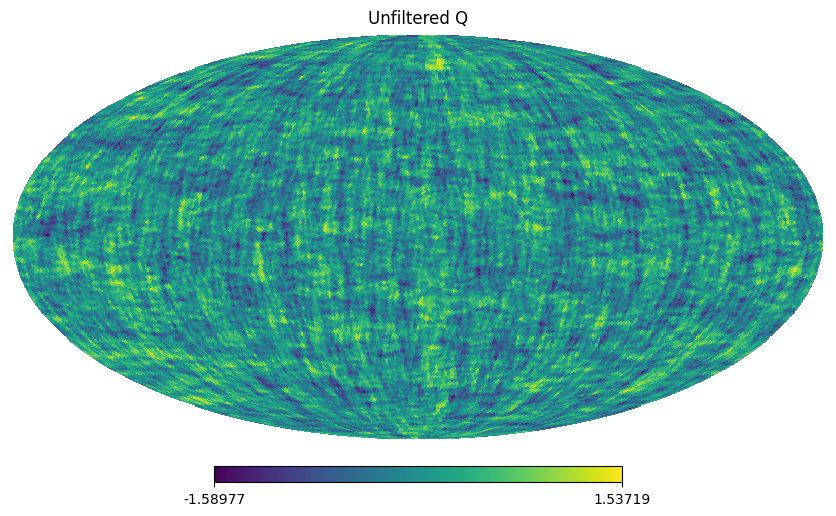

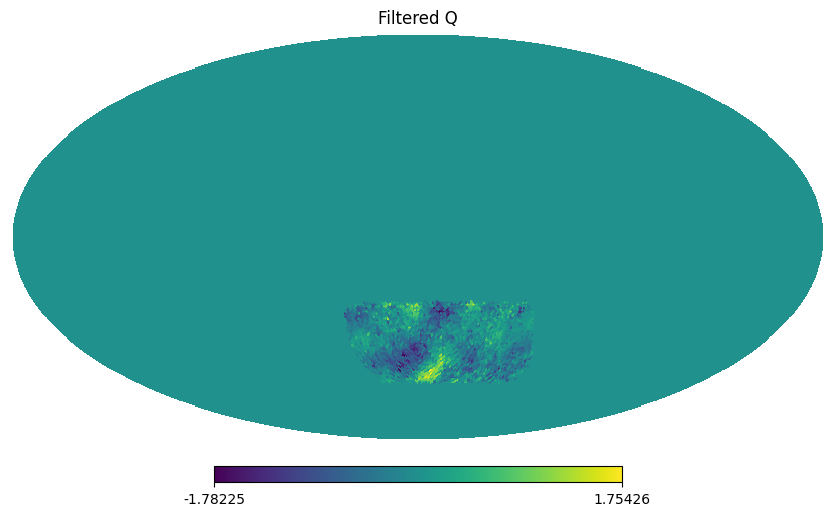

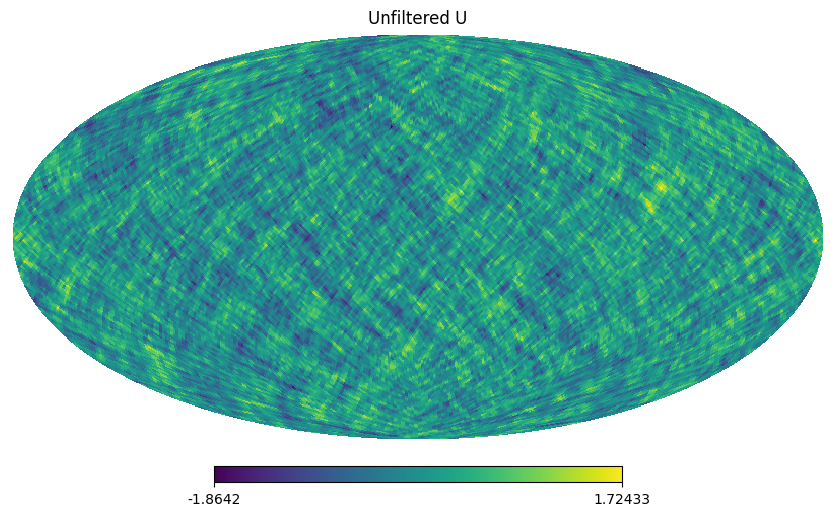

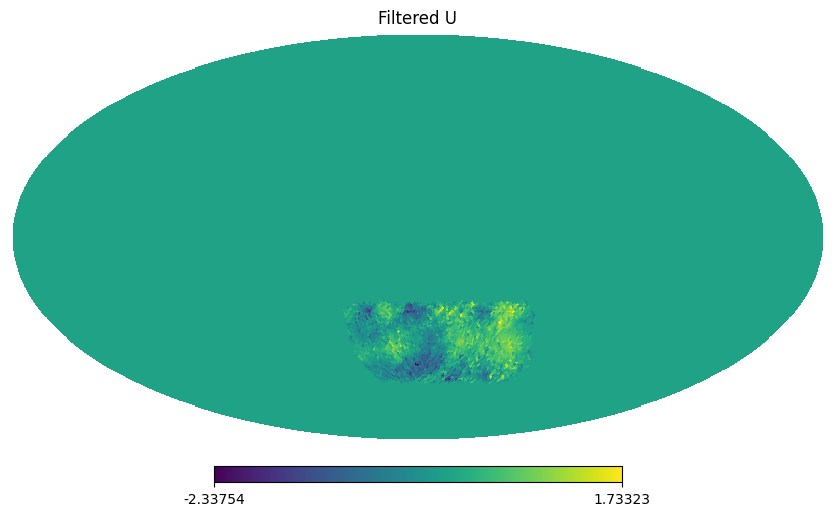

In [24]:
# Import mask
man = PipelineManager(config)
msk = hp.read_map(man.fname_binary_mask)
# Import
fout = f'{outdir}/filter_PL/plsim_1000_E.fits'
fin = 'data/PL/plsim_1000_E.fits'
# Read maps
mpQ, mpU = hp.read_map(fin, field=[1, 2])
mpQf, mpUf = hp.read_map(fout, field=[1, 2])

# Plot
plt.figure()
hp.mollview(mpQ, title='Unfiltered Q')
hp.mollview(mpQf, title='Filtered Q')
hp.mollview(mpU, title='Unfiltered U')
hp.mollview(mpUf, title='Filtered U')
plt.show()

### Compute their power spectra (before and after filtering)

In [25]:
#! {env_python_path} -m bbmaster.pcler --globals={config} --first-sim=0 --num-sims=2 --sim-sorter=pl_sim_names_EandB --output-dir={outdir} --sim-type=input
#! {env_python_path} -m bbmaster.pcler --globals={config} --first-sim=0 --num-sims=2 --sim-sorter=pl_sim_names_EandB --output-dir={outdir} --sim-type=filtered

   0.000: Log timestamps are relative to 2023-11-22 07:33:09,171 (INFO)
   0.000: Log timestamps are relative to 2023-11-22 07:33:16,226 (INFO)


Plot manually for one realisation

In [26]:
# Filtered
ffile = f'{outdir}/pcl_PL_filt/plsim_1000_pcl_filt.fits'
s = sacc.Sacc.load_fits(ffile)
# Input
ffile_in = f'{outdir}/pcl_PL_in/plsim_1000_pcl_in.fits'
sin = sacc.Sacc.load_fits(ffile_in)

In [27]:
# Select tracers 
tr1 = 'plsim_1000_E'
tr2 = 'plsim_1000_B'
# Get C_ells
l, cleb = s.get_ell_cl("cl_eb", tr1, tr2, return_cov=False)
l, clee = s.get_ell_cl("cl_ee", tr1, tr1, return_cov=False)
l, clbb = s.get_ell_cl("cl_bb", tr2, tr2, return_cov=False)

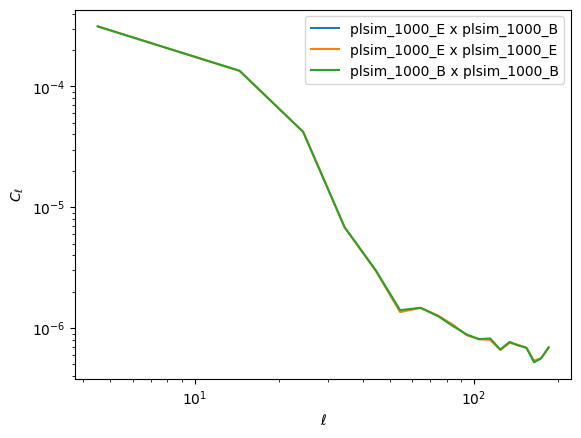

In [28]:
# Plot
plt.figure()
plt.plot(l, cleb, label=f'{tr1} x {tr2}')
plt.plot(l, clee, label=f'{tr1} x {tr1}')
plt.plot(l, clbb, label=f'{tr2} x {tr2}')
plt.ylabel('$C_\ell$')
plt.xlabel('$\ell$')
plt.loglog()
plt.legend()

### Estimate transfer function

In [31]:
#! {env_python_path} -m bbmaster.transfer --globals={config} --output-dir={outdir} --use-theory

   0.000: Log timestamps are relative to 2023-11-22 07:37:35,913 (INFO)
Nsims =  2


Manually plot

In [32]:
# Reliable ells
leff = s.get_ell_cl('cl_ee', tr1, tr2)[0]
goodl = leff < 2*man.nside

In [33]:
# Import 
fname = f'{outdir}transfer/transfer.npz'
ffile = np.load(fname)
list(ffile.keys())

['mcm',
 'bmcm',
 'transfer_function',
 'transfer_function_error',
 'bpw_windows',
 'wcal_inv',
 'input_cl',
 'filtered_cl']

In [34]:
trans = ffile['transfer_function']
cl_in = ffile['input_cl']
cl_filt = ffile['filtered_cl']

In [35]:
# Now recover Cl_filt from Cl_in
cl_filt_r = np.einsum('ijl,kjl->kil', trans, cl_in)

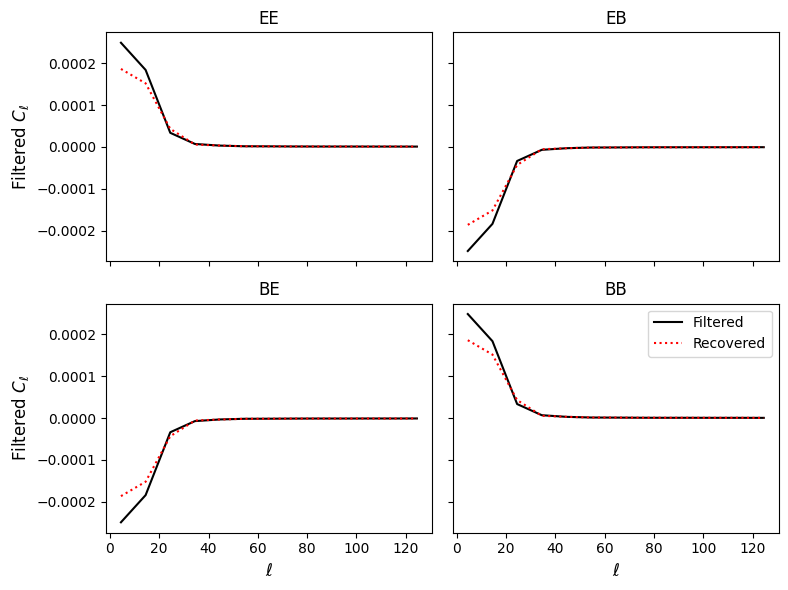

In [36]:
combs = ['EE', 'EB', 'BE', 'BB']
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey='row')
for i, comb in enumerate(combs):
    row, col = divmod(i, 2)
    ax = axs[row, col]
    ax.set_title(comb)
    ax.plot(leff[goodl], cl_filt[i, i][goodl], 'k-', label='Filtered')
    ax.plot(leff[goodl], cl_filt_r[i, i][goodl], 'r:', label='Recovered')
plt.legend()
# Add x-label to the bottom row of subplots
for col in range(2):
    axs[1, col].set_xlabel('$\ell$', fontsize=12)
# Add y-label to the left column of subplots
for row in range(2):
    axs[row, 0].set_ylabel('Filtered $C_\ell$', fontsize=12)
plt.tight_layout()
plt.show()

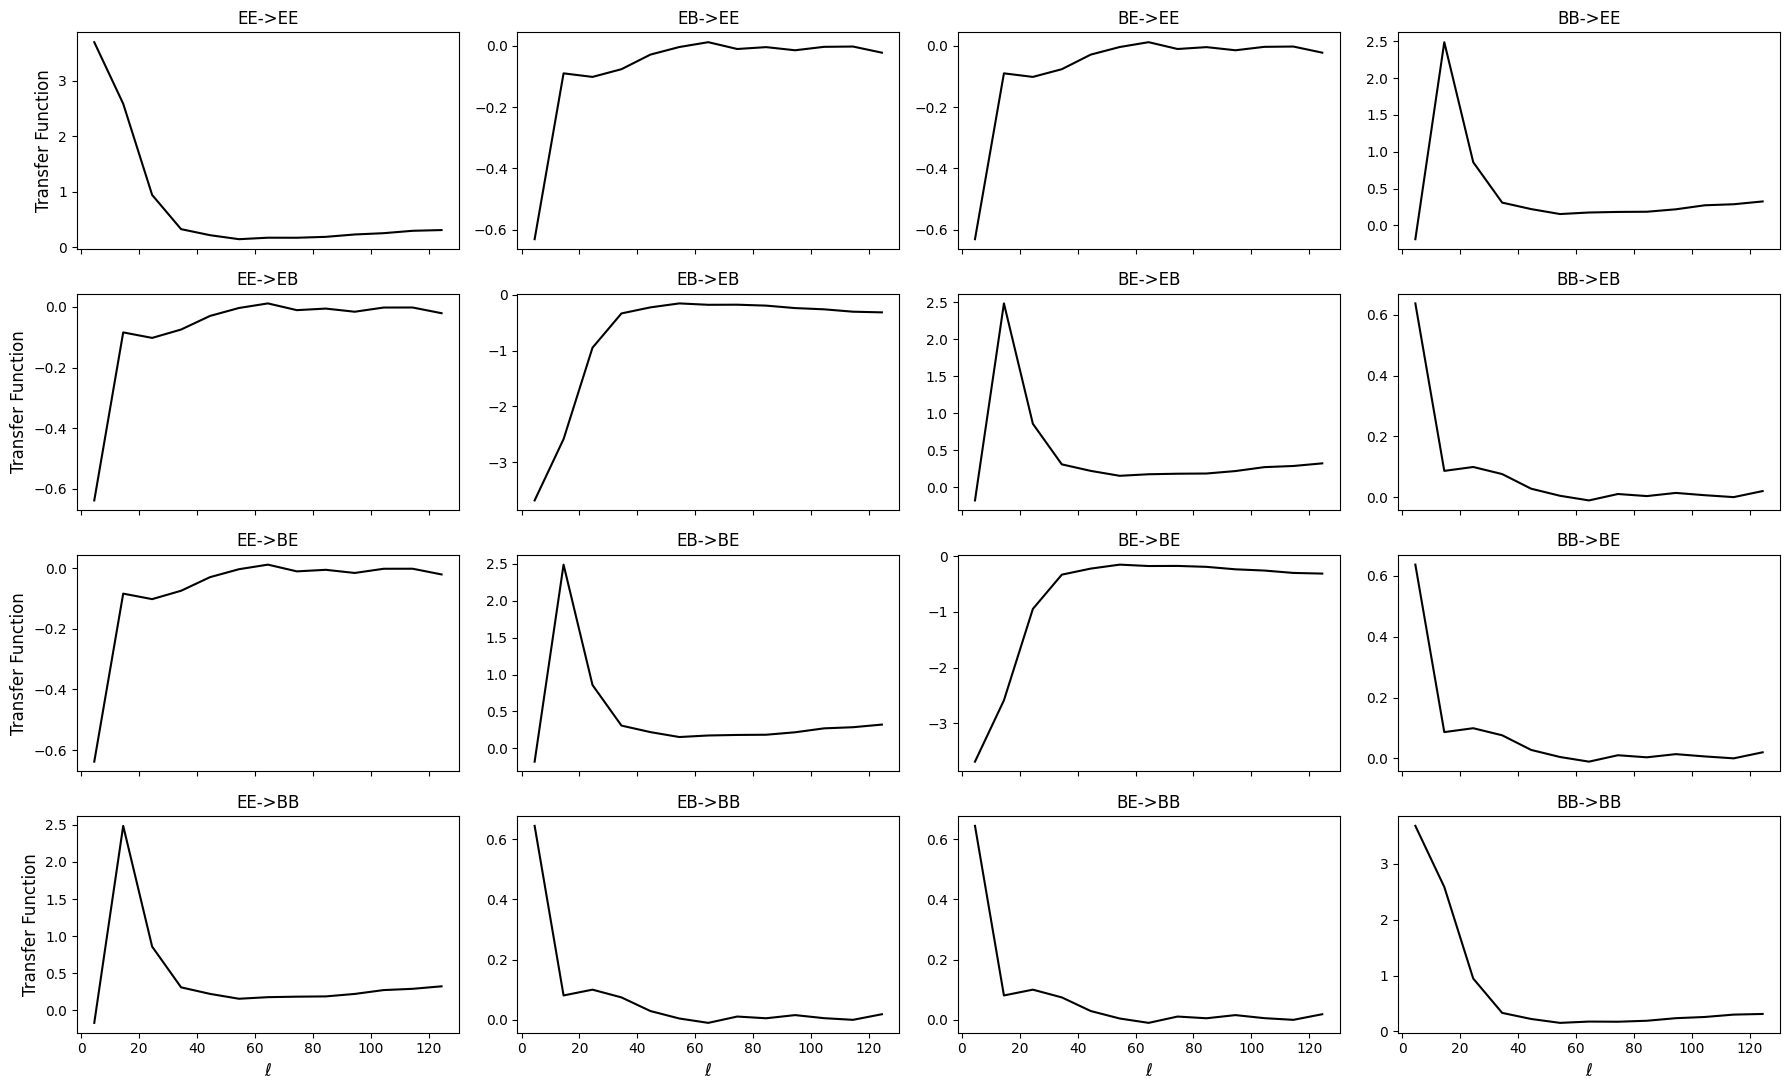

In [37]:
fig, axs = plt.subplots(4, 4, figsize=(18, 11), sharex=True)
for i1, comb1 in enumerate(combs):
    for i2, comb2 in enumerate(combs):
        ax = axs[i1, i2]
        ax.set_title(f'{comb2}->{comb1}')
        ax.plot(leff[goodl], trans[i1, i2][goodl], 'k-')
# Add x-label to the bottom row of subplots
for i2, comb2 in enumerate(combs):
    axs[3, i2].set_xlabel('$\ell$', fontsize=12)
# Add y-label to the leftmost column of subplots
for i1, comb1 in enumerate(combs):
    axs[i1, 0].set_ylabel('Transfer Function', fontsize=12)
plt.tight_layout()
plt.show()

### Filter validation sims and computer their PCL

In [40]:
# Filter all validation sims 
! {env_python_path} -m bbmaster.filterer_toast --globals={config} --first-sim=0 --num-sims=1 --sim-sorter=val_sim_names --output-dir={outdir}  

   0.000: Log timestamps are relative to 2023-11-22 07:41:09,431 (INFO)
data/val/cmb_SAT_f090_ns64_seed1000.fits
bbmaster/outputs_5hrs/filter_val/cmb_SAT_f090_ns64_seed1000.fits
bbmaster/outputs_5hrs/filter_val/cmb_SAT_f090_ns64_seed1000/
Read schedule
TOAST INFO: Loading schedule from data/schedules/schedule_sat_5hr.txt
TOAST INFO: Loaded 16 scans from data/schedules/schedule_sat_5hr.txt totaling 5.32 hours.
Initialize focal plane and telescope
Apply filters
TOAST INFO: Pixel data in data/val/cmb_SAT_f090_ns64_seed1000.fits does not have TUNIT1 key.  Assuming 'K'.
Save hdf5 and context files
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_val/cmb_SAT_f090_ns64_seed1000/obs_south-0-0_959754943.h5
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_val/cmb_SAT_f090_ns64_seed1000/obs_south-0-1_1992400164.h5
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_val/cmb_SAT_f090_ns64_seed1000/obs_south-0-2_2319226194.h5
TOAST INFO: Wrote bbmaster/outputs_5hrs/filter_val/cmb_SAT_f090_ns64_seed1000/obs_s

Manually plot 1 sim

<Figure size 640x480 with 0 Axes>

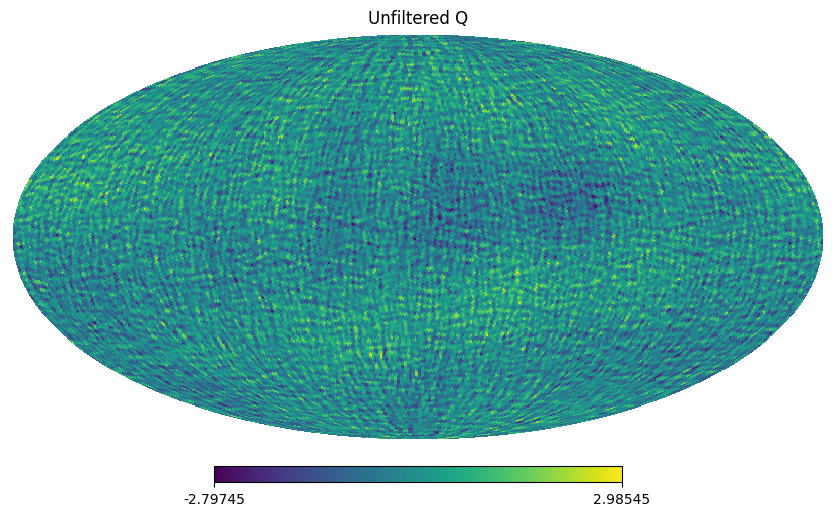

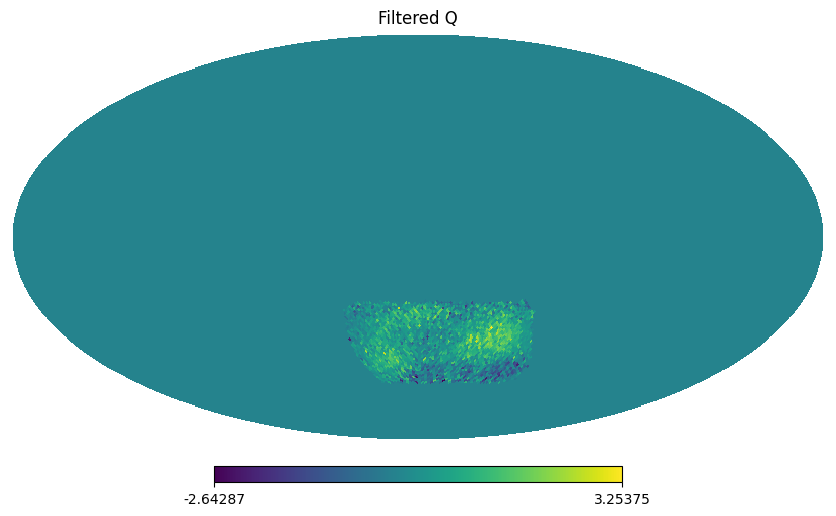

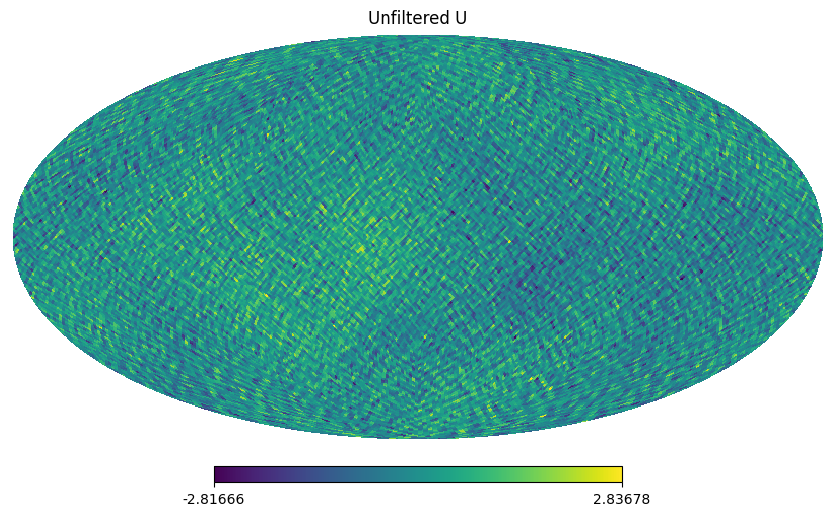

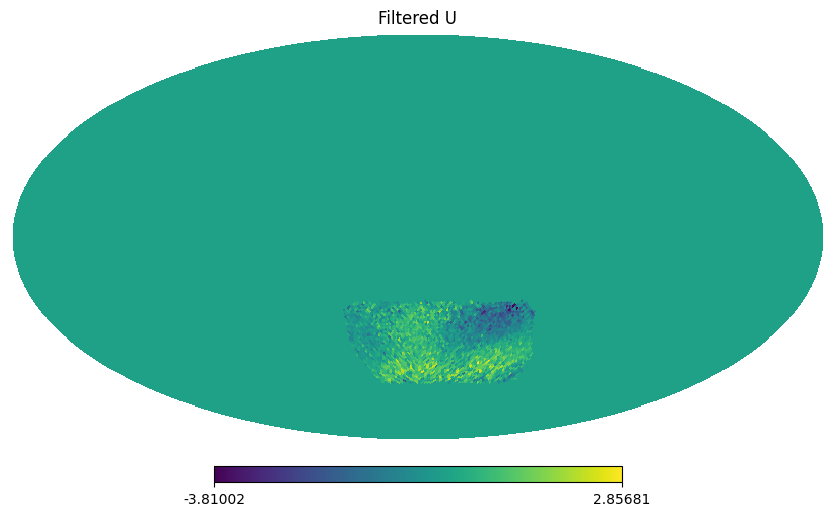

In [42]:
fin = 'data/CMBr/CMBr_1000.fits'
fout = f'{outdir}/filter_val/cmb_SAT_f090_ns64_seed1000.fits'

# Read maps
mpQ, mpU = hp.read_map(fin, field=[1, 2])
mpQf, mpUf = hp.read_map(fout, field=[1, 2])

# Plot
plt.figure()
hp.mollview(mpQ, title='Unfiltered Q')
hp.mollview(mpQf, title='Filtered Q')
hp.mollview(mpU, title='Unfiltered U')
hp.mollview(mpUf, title='Filtered U')
plt.show()

### Estimate their pseudo-$C_{\ell}$ before and after filtering and their decoupled versions

In [46]:
# Estimate PCL before filtering
! {env_python_path} -m bbmaster.pcler --globals={config} --output-dir={outdir} --first-sim=0 --num-sims=1 --sim-sorter=val_sim_names --sim-type=input

   0.000: Log timestamps are relative to 2023-11-22 07:49:17,139 (INFO)


In [47]:
# After filtering
! {env_python_path} -m bbmaster.pcler --globals={config} --output-dir={outdir} --first-sim=0 --num-sims=1 --sim-sorter=val_sim_names --sim-type=filtered

   0.000: Log timestamps are relative to 2023-11-22 07:49:23,319 (INFO)


In [48]:
# Decoupled C_ells
! {env_python_path} -m bbmaster.pcler --globals={config} --output-dir={outdir} --first-sim=0 --num-sims=1 --sim-sorter=val_sim_names --correct-transfer --sim-type=decoupled 

   0.000: Log timestamps are relative to 2023-11-22 07:49:28,761 (INFO)


Manually plot for 1 sim

In [50]:
# Import sims
# Filtered
vile_filt = f'{outdir}/pcl_val_filt/cmb_SAT_f090_ns64_seed1000_pcl_filt.fits'
s = sacc.Sacc.load_fits(vile_filt)
# Input
vile_in = f'{outdir}/pcl_val_in/cmb_SAT_f090_ns64_seed1000_pcl_in.fits'
sin = sacc.Sacc.load_fits(vile_in)
# Decoupled
vile_dec = f'{outdir}/cl_val/cmb_SAT_f090_ns64_seed1000_cl.fits'
sdec = sacc.Sacc.load_fits(vile_dec)

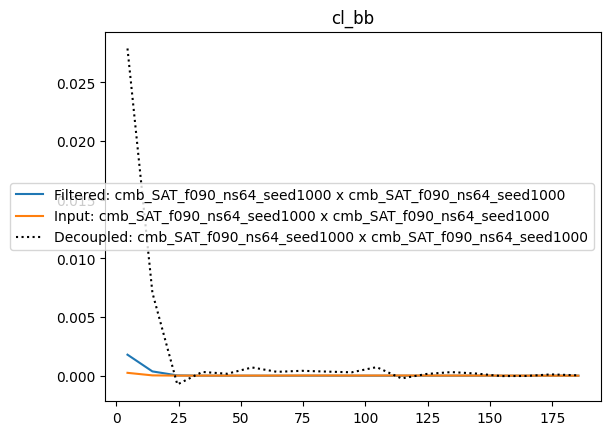

In [51]:
# Compare input, filtered, decoupled
pols = ['cl_bb']
for pol in pols:
    plt.figure()
    plt.title(pol)
    for tr1 in s.tracers:
        l, cl = s.get_ell_cl("cl_ee", tr1, tr1, return_cov=False) 
        plt.plot(l, cl, label=f'Filtered: {tr1} x {tr1}')
        lin, clin = sin.get_ell_cl("cl_ee", tr1, tr1, return_cov=False) 
        plt.plot(lin, clin, label=f'Input: {tr1} x {tr1}')
        ldec, cldec = sdec.get_ell_cl("cl_ee", tr1, tr1, return_cov=False) 
        plt.plot(ldec, cldec, 'k:', label=f'Decoupled: {tr1} x {tr1}')
        #plt.loglog()
        plt.legend()

### Validate transfer function

In [53]:
# Validate transfer function
! {env_python_path} -m bbmaster.transfer_validator --globals={config} --output-dir={outdir}

   0.000: Log timestamps are relative to 2023-11-22 07:52:05,418 (INFO)
bbmaster/outputs_5hrs/
bbmaster/outputs_5hrs/transfer/transfer_validation.npz


Manually plot 

In [54]:
# Read Cls mean and std calculated above
fname_transferval = f'{outdir}/transfer/transfer_validation.npz'
transfval = np.load(fname_transferval)

cl_in = transfval['input_cl']
ecl_in = transfval['error_input_cl']
cl_filt = transfval['filtered_cl']
ecl_filt = transfval['error_filtered_cl']
cl_dec = transfval['decoupled_cl']
ecl_dec = transfval['error_decoupled_cl']

In [55]:
# Compute theoretical predictions transfer function
fname_transfer = f'{outdir}transfer/transfer.npz'
transf = np.load(fname_transfer)

cl_in_th = np.einsum('ijkl,kl', transf['bmcm'], man.cls_val)
cl_filt_th = np.einsum('ijk,jk->ik', transf['transfer_function'], cl_in_th)
cl_dec_th = np.einsum('ijkl,kl', transf['bpw_windows'], man.cls_val)

In [56]:
# Determine ells to use in comparison
tf = transf['transfer_function'][0, 0]
goodl = (tf > 0.05) & (leff < 2*man.nside)

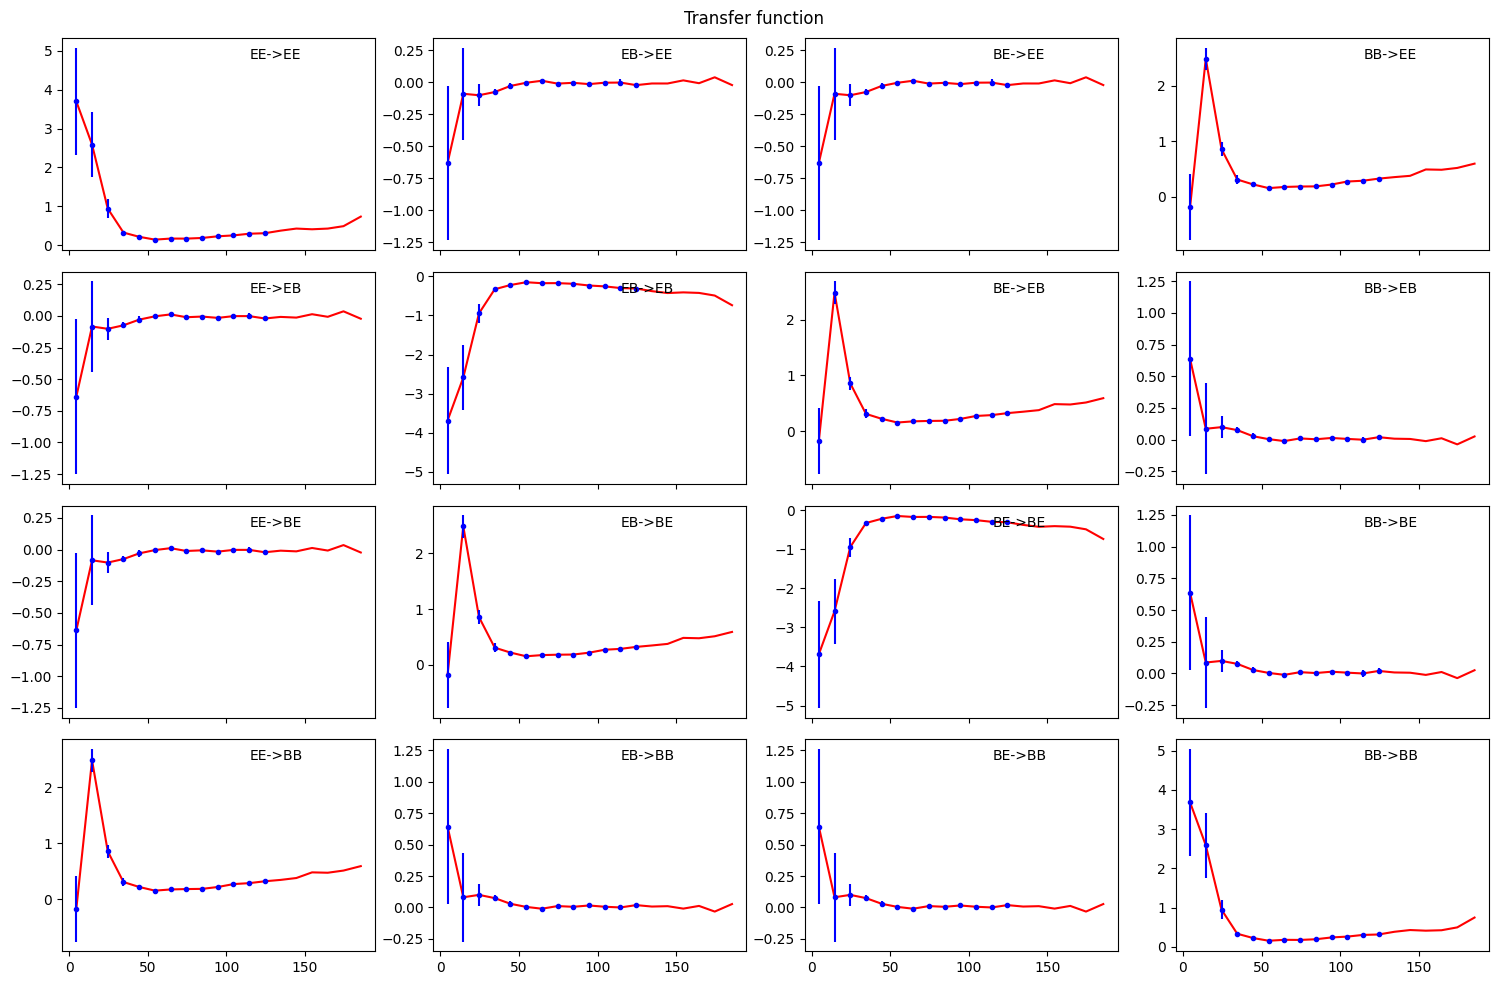

In [57]:
titles = ['EE', 'EB', 'BE', 'BB']
# Transfer function
fig, axes = plt.subplots(4, 4, figsize=(15, 10),sharex=True)
fig.suptitle("Transfer function")
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        ax.plot(leff, transf['transfer_function'][i, j], 'r-')
        ax.errorbar(leff[goodl], transf['transfer_function'][i, j][goodl],
                    yerr=transf['transfer_function_error'][i, j][goodl],
                    fmt='b.')
        ax.text(0.6, 0.9, f'{titles[j]}->{titles[i]}', transform=ax.transAxes)
plt.tight_layout()

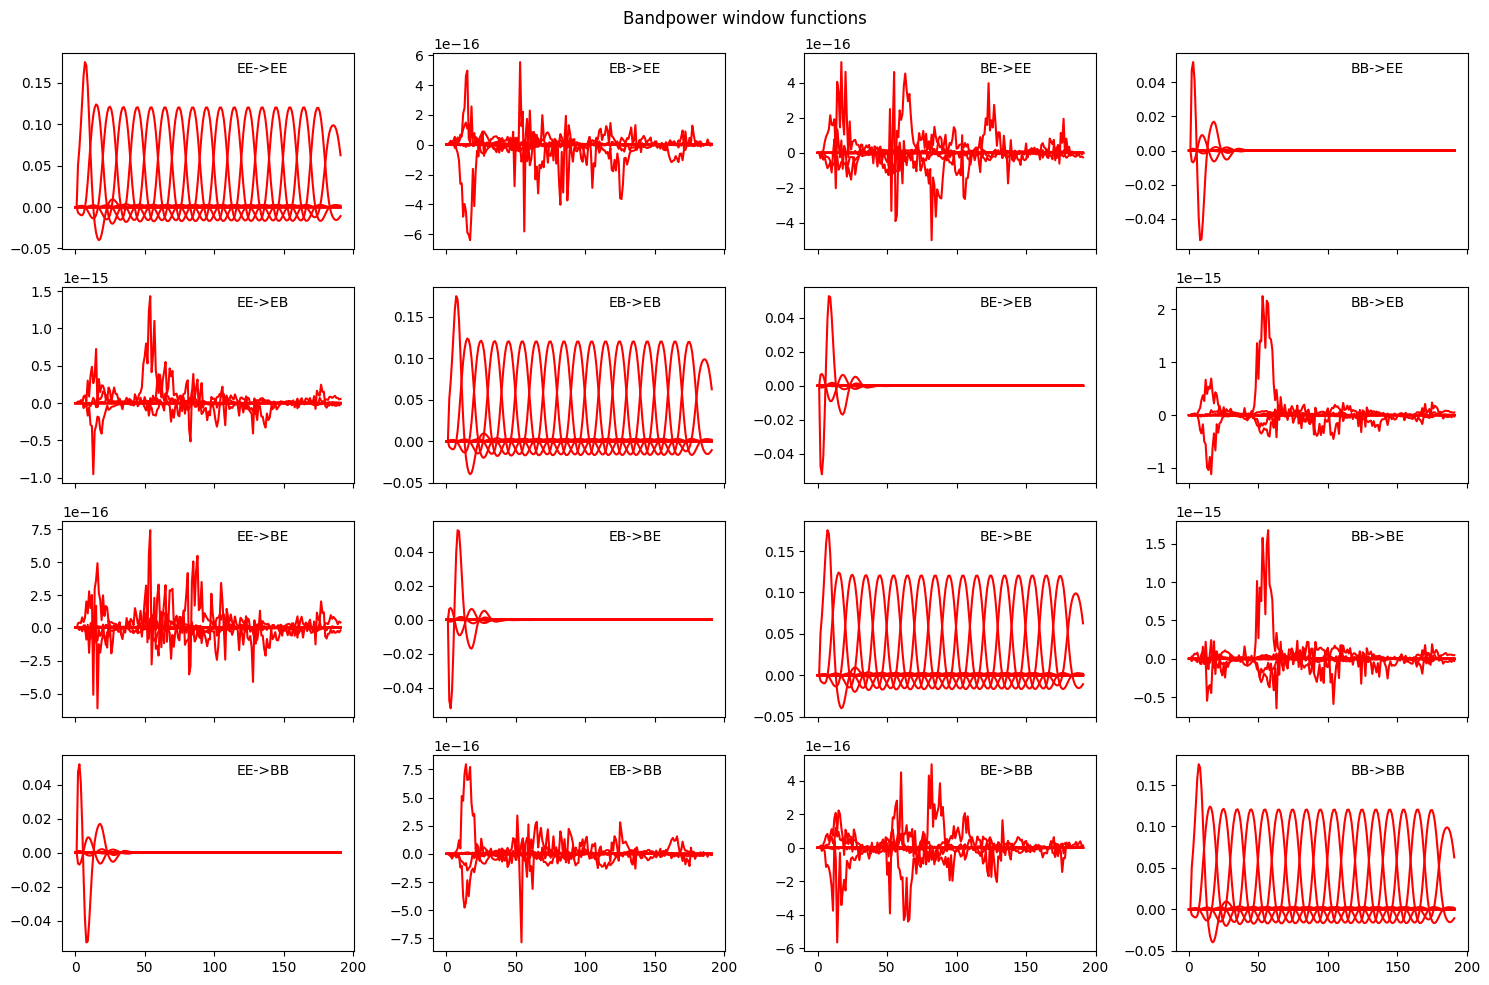

In [58]:
# Bandpower window functions 
bpw = transf['bpw_windows']
fig, axes = plt.subplots(4, 4, figsize=(15, 10),sharex=True)
fig.suptitle("Bandpower window functions")
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        for k in range(len(leff)):
            ax.plot(bpw[i, k, j, :], 'r-')
        ax.text(0.6, 0.9, f'{titles[j]}->{titles[i]}',
                transform=ax.transAxes)
plt.tight_layout()

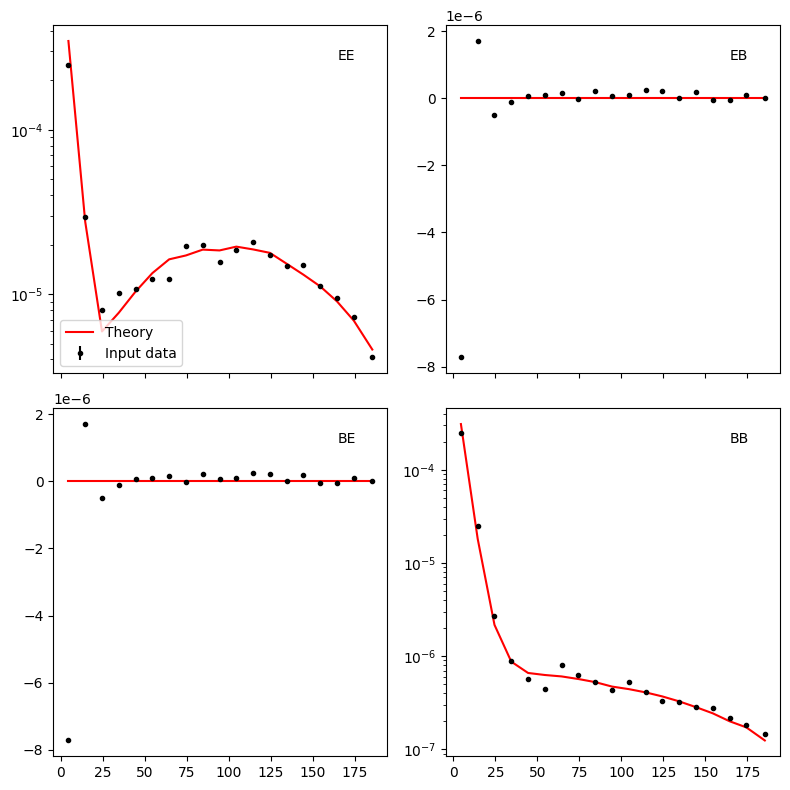

In [59]:
# Input spectra 
fig.suptitle("Masked PCLs")
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.errorbar(leff, cl_in[i], yerr=ecl_in[i], fmt='k.', label='Input data')
    ax.plot(leff, cl_in_th[i], 'r-', label='Theory')
    if i in [0, 3]:  # Log-scale for EE and BB
        ax.set_yscale('log')
    ax.text(0.85, 0.9, titles[i], transform=ax.transAxes)
    if i == 0:
        ax.legend(loc='lower left')
plt.tight_layout()

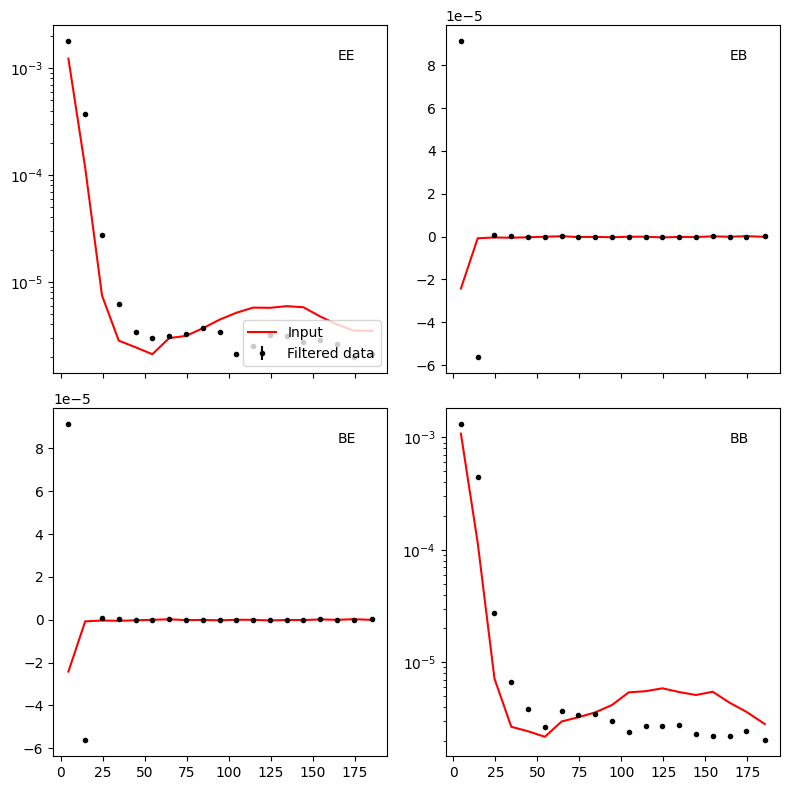

In [60]:
# Filtered spectra 
fig.suptitle("Filtered PCLs")
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.errorbar(leff, cl_filt[i], yerr=ecl_filt[i], fmt='k.', label='Filtered data')
    ax.plot(leff, cl_filt_th[i], 'r-', label='Input')
    if i in [0, 3]:  # Log-scale for EE and BB
        ax.set_yscale('log')
    ax.text(0.85, 0.9, titles[i], transform=ax.transAxes)
    if i == 0:
        ax.legend(loc='lower right')
plt.tight_layout()

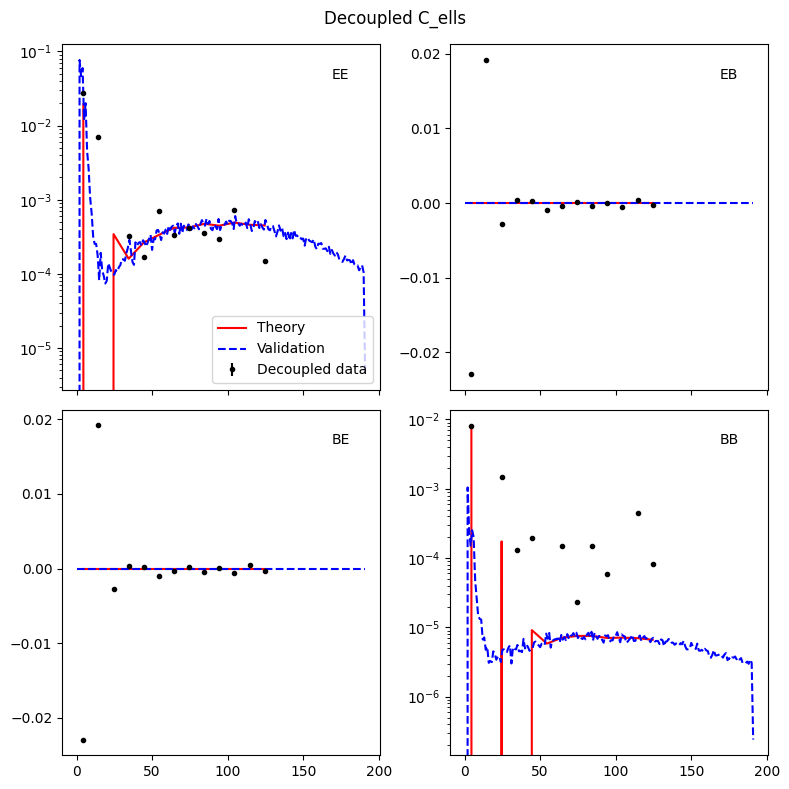

In [61]:
# Decoupled spectra 
lth = np.arange(3*man.nside)
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
fig.suptitle("Decoupled C_ells")
for i, ax in enumerate(axes.flatten()):
    ax.errorbar(leff[goodl], cl_dec[i][goodl],
                yerr=ecl_dec[i][goodl], fmt='k.', label='Decoupled data')
    ax.plot(leff[goodl], cl_dec_th[i][goodl], 'r-', label='Theory')
    ax.plot(lth, man.cls_val[i], 'b--', label='Validation')
    if i in [0, 3]:  # Log-scale for EE and BB
        ax.set_yscale('log')
    if i == 0:
        ax.legend(loc='lower right')
    ax.text(0.85, 0.9, titles[i], transform=ax.transAxes)
plt.tight_layout()

#### Continue to the next section

Go to [Section 7 - Estimate r](Sec7_Estimate_r.ipynb).